## Section 1 — Import Libraries

In this section, we import all the required Python libraries used for:

- Loading and visualizing images  
- Training the YOLO detection model  
- Handling file paths  

These imports prepare the environment for the rest of the project.

In [2]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [6]:
dataset_path = Path("archive/images")

# List first 5 image filenames (PNG files)
image_files = sorted(dataset_path.glob("*.png"))

print("Number of images:", len(image_files))
print("First 5 images:", image_files[:5])

Number of images: 433
First 5 images: [PosixPath('archive/images/Cars0.png'), PosixPath('archive/images/Cars1.png'), PosixPath('archive/images/Cars10.png'), PosixPath('archive/images/Cars100.png'), PosixPath('archive/images/Cars101.png')]


## Section 2 — Dataset Exploration

Before training a detection model, we first explore the dataset to understand what the images look like.  
We will:

- Load sample images  
- Visualize them  
- Confirm the dataset paths are correct  

This helps ensure that the model receives the right type of input and that the dataset structure is properly recognized.


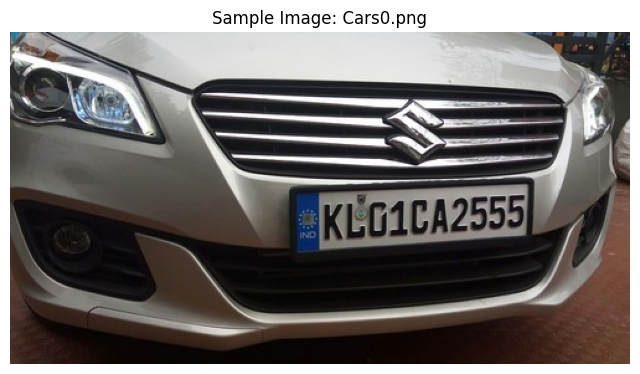

In [7]:
# Display one sample image

sample_img_path = image_files[0]  # first image in the dataset

# Load image using OpenCV (BGR format)
img = cv2.imread(str(sample_img_path))

# Convert BGR → RGB for correct display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Sample Image: {sample_img_path.name}")
plt.show()

## Section 3 — Annotations and YOLO Format

The original dataset provides bounding box annotations in **Pascal VOC (XML) format**.  
However, the YOLO model expects annotations in a different text format:

`class_id x_center y_center width height`

All coordinates are **normalized** (between 0 and 1), relative to the image size.

In this section, we:
- Read the XML annotation files
- Extract the license plate bounding box
- Convert each annotation to YOLO format
- Save the result as a `.txt` file for each image


In [13]:
import xml.etree.ElementTree as ET

annotations_path = Path("archive/annotations")
labels_path = Path("archive/labels_yolo")

# Create output folder for YOLO labels
labels_path.mkdir(exist_ok=True)

# We have only ONE class: license plate
class_id = 0

def convert_bbox_to_yolo(size, bbox):
    """
    size: (image_width, image_height)
    bbox: (xmin, ymin, xmax, ymax)
    returns: (x_center, y_center, width, height) normalized between 0 and 1
    """
    img_w, img_h = size
    xmin, ymin, xmax, ymax = bbox

    x_center = (xmin + xmax) / 2.0 / img_w
    y_center = (ymin + ymax) / 2.0 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h

    return x_center, y_center, width, height


num_files = 0

for xml_file in annotations_path.glob("*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # image size
    img_w = int(root.find("size/width").text)
    img_h = int(root.find("size/height").text)

    # each object = one license plate
    yolo_lines = []

    for obj in root.findall("object"):
        # name = class label, here it's always license-plate-like
        # you could check obj.find("name").text if needed
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        x_c, y_c, w, h = convert_bbox_to_yolo((img_w, img_h), (xmin, ymin, xmax, ymax))
        yolo_lines.append(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

    # Save .txt file with same base name as image
    txt_filename = labels_path / (xml_file.stem + ".txt")
    with open(txt_filename, "w") as f:
        for line in yolo_lines:
            f.write(line + "\n")

    num_files += 1

print(f"Converted {num_files} annotation files to YOLO format.")
print("YOLO label samples from 'archive/labels_yolo':", list(labels_path.glob('*.txt'))[:5])

Converted 433 annotation files to YOLO format.
YOLO label samples from 'archive/labels_yolo': [PosixPath('archive/labels_yolo/Cars311.txt'), PosixPath('archive/labels_yolo/Cars305.txt'), PosixPath('archive/labels_yolo/Cars339.txt'), PosixPath('archive/labels_yolo/Cars113.txt'), PosixPath('archive/labels_yolo/Cars2.txt')]


## Section 4 — Preparing YOLO Dataset (Train / Validation Split)

To train YOLO, we need a specific folder structure with separate sets for training and validation:

- `images/train` and `images/val`
- `labels/train` and `labels/val`

In this section, we:
- Pair each image with its corresponding YOLO label file  
- Randomly split the dataset into training (e.g., 80%) and validation (20%)  
- Copy the files into a new `yolo_dataset` folder with the structure expected by YOLO.


In [14]:
import random
import shutil

# Use the same dataset and labels paths as before
images_path = Path("archive/images")
labels_path = Path("archive/labels_yolo")

# Make sure images are sorted (for consistency only)
all_images = sorted(images_path.glob("*.png"))

# Pair each image with its corresponding label file
image_label_pairs = []
for img_path in all_images:
    label_path = labels_path / (img_path.stem + ".txt")
    if label_path.exists():
        image_label_pairs.append((img_path, label_path))
    else:
        print(f"Warning: no label for image {img_path.name}")

print("Total paired image+label files:", len(image_label_pairs))

# Shuffle and split into train and validation sets (80% / 20%)
random.shuffle(image_label_pairs)
split_idx = int(0.8 * len(image_label_pairs))

train_pairs = image_label_pairs[:split_idx]
val_pairs = image_label_pairs[split_idx:]

print(f"Training samples: {len(train_pairs)}")
print(f"Validation samples: {len(val_pairs)}")

# Create YOLO-style directory structure
yolo_base = Path("yolo_dataset")
images_train_dir = yolo_base / "images" / "train"
images_val_dir = yolo_base / "images" / "val"
labels_train_dir = yolo_base / "labels" / "train"
labels_val_dir = yolo_base / "labels" / "val"

for d in [images_train_dir, images_val_dir, labels_train_dir, labels_val_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Copy files into their respective folders
def copy_pairs(pairs, img_dest_dir, label_dest_dir):
    for img_path, label_path in pairs:
        shutil.copy2(img_path, img_dest_dir / img_path.name)
        shutil.copy2(label_path, label_dest_dir / label_path.name)

copy_pairs(train_pairs, images_train_dir, labels_train_dir)
copy_pairs(val_pairs, images_val_dir, labels_val_dir)

print("Finished copying files into yolo_dataset folder.")

Total paired image+label files: 433
Training samples: 346
Validation samples: 87
Finished copying files into yolo_dataset folder.


## Section 5 — Training the YOLO Detection Model

In this section, we fine-tune a pretrained **YOLOv8** object detection model on our license plate dataset.

Key ideas:
- We start from a pretrained model (`yolov8n.pt`) so training is faster and easier.
- We use the `data.yaml` file to tell YOLO where the images and labels are.
- The model learns to detect and localize license plates by seeing many examples.

We will:
- Load the YOLOv8 model
- Train it on the `yolo_dataset` (train/val)
- Save the trained weights and training metrics for evaluation


In [15]:
# Load a pretrained YOLOv8 model (nano version: small and fast)
model = YOLO("yolov8n.pt")  # this will download the weights if not already present

# Train the model on our license plate dataset
results = model.train(
    data="data.yaml",   # path to our dataset config
    epochs=20,          
    imgsz=640,          # image size
    batch=16           
)

WARNING ⚠️ Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n.pt... <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)>


######################################################################## 100.0%


Ultralytics 8.3.228 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M2)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, pro

## Section 6 — Evaluation and Visualization of Detected License Plates

After training the YOLO model, we evaluate its performance and visualize its predictions.

Key points:
- We use the trained model to run inference on validation images.
- The model draws bounding boxes around the detected license plates.
- These visual results help us understand how well the model works in real scenarios.

In this section, we:
- Load the best trained model checkpoint
- Run detection on sample images
- Display the images with predicted bounding boxes


In [16]:
# Load the trained YOLO model
best_model_path = "runs/detect/train/weights/best.pt"
trained_model = YOLO(best_model_path)
print("Loaded trained model from:", best_model_path)


Loaded trained model from: runs/detect/train/weights/best.pt


Using validation image: Cars171.png


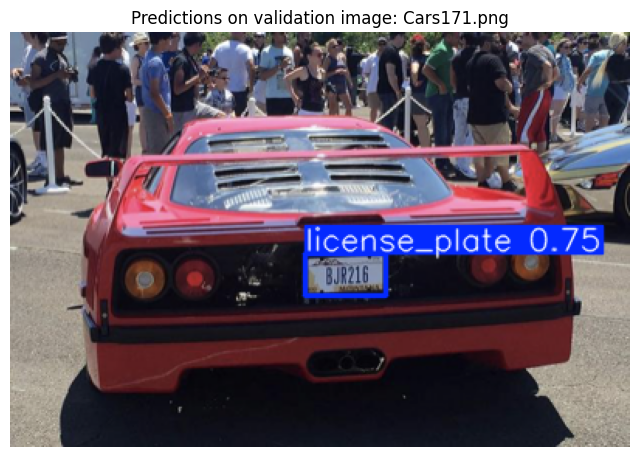

In [19]:
# Pick one sample image from the validation set
sample_val_image = next(images_val_dir.glob("*.png"))
print("Using validation image:", sample_val_image.name)

# Run detection
results = trained_model.predict(source=str(sample_val_image), conf=0.25, verbose=False)

# Get the first result and plot it
res = results[0]
annotated_img = res.plot()  # this returns a BGR image with boxes drawn

# Convert BGR -> RGB for display
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(annotated_img_rgb)
plt.axis("off")
plt.title(f"Predictions on validation image: {sample_val_image.name}")
plt.show()

### Section 6.1 — Generating Result Images for the Report and Slides

To illustrate the performance of our model, we generate predictions on a few **validation images** (images not seen during training).

In this subsection, we:
- Select 3 random images from the validation set  
- Run the trained YOLO model on each image  
- Visualize the detected license plates  
- Save the resulting images to disk for use in the presentation slides


Selected validation images:
 - Cars204.png
 - Cars74.png
 - Cars129.png


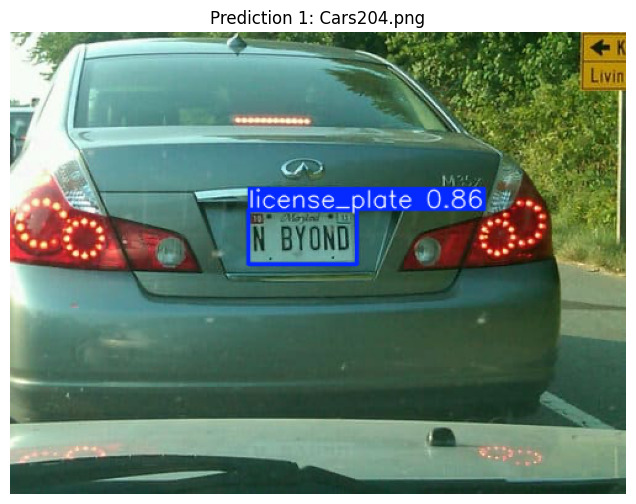

Saved: result_images/prediction_1_Cars204.png


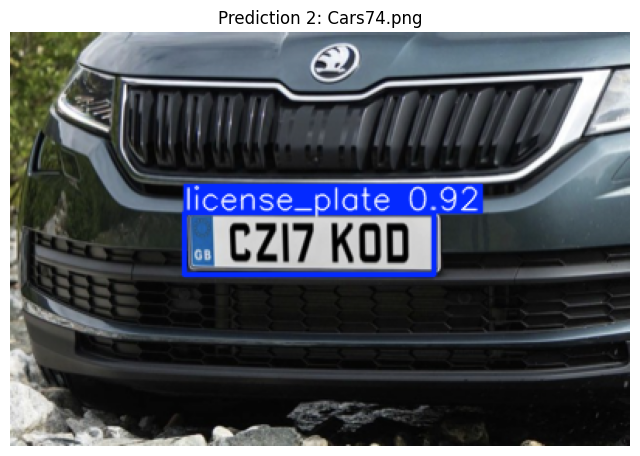

Saved: result_images/prediction_2_Cars74.png


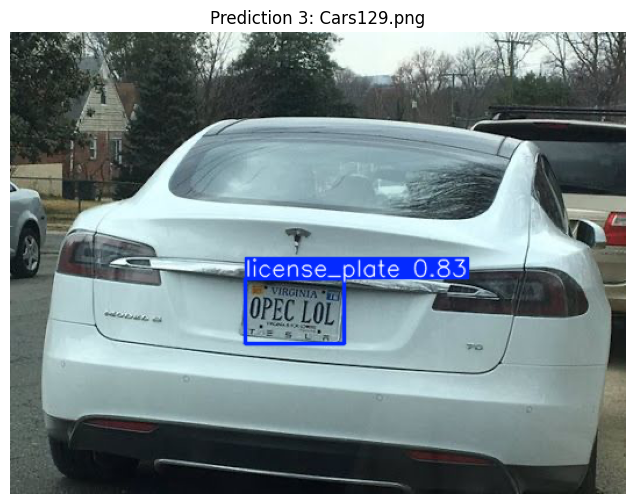

Saved: result_images/prediction_3_Cars129.png


In [20]:
import random

from pathlib import Path
val_images_dir = Path("yolo_dataset/images/val")

# Create an output folder for slide-ready result images
results_dir = Path("result_images")
results_dir.mkdir(exist_ok=True)

# Get all validation images (PNG)
val_images = sorted(val_images_dir.glob("*.png"))

# Pick 3 random validation images
sample_val_images = random.sample(val_images, 3)
print("Selected validation images:")
for p in sample_val_images:
    print(" -", p.name)

for i, img_path in enumerate(sample_val_images, start=1):
    # Run detection
    results = trained_model.predict(source=str(img_path), conf=0.25, verbose=False)
    res = results[0]

    # Get annotated image (with boxes)
    annotated = res.plot()  # BGR
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    # Display
    plt.figure(figsize=(8, 6))
    plt.imshow(annotated_rgb)
    plt.axis("off")
    plt.title(f"Prediction {i}: {img_path.name}")
    plt.show()

    # Save to disk for presentation
    out_path = results_dir / f"prediction_{i}_{img_path.stem}.png"
    cv2.imwrite(str(out_path), annotated)  # save in BGR
    print(f"Saved: {out_path}")